# Resume Scoring

### Creating word embedding 

In [1]:
from gensim.models import Word2Vec
import string
from nltk.corpus import stopwords
with open('C:\\Users\\dell\\Desktop\\NLP\\skills.txt',encoding="utf8") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

In [2]:
content[1]

'Data science is a "concept to unify statistics, data analysis, machine learning and their related methods" in order to "understand and analyze actual phenomena" with data.[4] It employs techniques and theories drawn from many fields within the context of mathematics, statistics, information science, and computer science. Turing award winner Jim Gray imagined data science as a "fourth paradigm" of science (empirical, theoretical, computational and now data-driven) and asserted that "everything about science is changing because of the impact of information technology" and the data deluge.[5][6]'

In [3]:
from nltk.tokenize import word_tokenize
import gensim
from gensim.models.phrases import Phraser, Phrases

In [4]:
x=[]
for line in content:
    tokens=word_tokenize(line)
    tok=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    strpp=[w.translate(table) for w in tok]
    words=[word for word in strpp if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    words=[w for w in words if not w in stop_words]
    x.append(words)

In [5]:

common_terms = ["of", "with", "without", "and", "or", "the", "a"]

# Create the relevant phrases from the list of sentences:
phrases = Phrases(x, common_terms=common_terms)
# The Phraser object is used from now on to transform sentences
bigram = Phraser(phrases)
# Applying the Phraser to transform our sentences is simply
all_sentences = list(bigram[x])
model=gensim.models.Word2Vec(all_sentences,size=5000,min_count=2,workers=4,window=4)
model.save("final.model")
wrds=list(model.wv.vocab)
print(len(wrds))


1279


In [6]:
z=model.wv.most_similar("machine_learning")

In [7]:
print(z)

[('software', 0.1542699784040451), ('may', 0.1504892110824585), ('deep_learning', 0.14806760847568512), ('data', 0.1433940827846527), ('systems', 0.13984887301921844), ('java', 0.13831689953804016), ('data_science', 0.1382388025522232), ('information', 0.13371220231056213), ('language', 0.13265997171401978), ('new', 0.1296333223581314)]


### Resume Parsing

In [8]:
import PyPDF2
import os
import collections
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [9]:
mypath=r'C:\Users\dell\Desktop\New folder\ML_CS\NLP\Resume'
#Path for the files
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


In [10]:
import collections
def pdfextract(file):
    pdf_file = open(file, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    for i in c:
        #page
        page = read_pdf.getPage(i)
        page_content = page.extractText()
    return (page_content.encode('utf-8'))

In [12]:
sim_words=[k[0] for k in model.wv.most_similar("machine_learning")]

In [35]:
def create_profile(file):
    model=Word2Vec.load("final.model")
    text = str(pdfextract(file))
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    #keyword_dictionary = pd.read_csv(r'C:\Users\dell\Desktop\New folder\ML_CS\NLP\technical_skills.csv')
    stats = [nlp(text[0]) for text in model.wv.most_similar("statistics")]
    NLP = [nlp(text[0]) for text in model.wv.most_similar("language")]
    ML = [nlp(text[0]) for text in model.wv.most_similar("machine_learning")]
    DL = [nlp(text[0]) for text in model.wv.most_similar("deep")]
    #R = [nlp(text) for text in keyword_dictionary['R Language'].dropna(axis = 0)]
    python = [nlp(text[0]) for text in model.wv.most_similar("python")]
    Data_Engineering = [nlp(text[0]) for text in model.wv.most_similar("data")]
    print("*******************************************")
    #print(stats_words,NLP_words)
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats)
    matcher.add('NLP', None, *NLP)
    matcher.add('ML', None, *ML)
    matcher.add('DL', None, *DL)
    matcher.add('Python', None, *python)
    matcher.add('DE', None, *Data_Engineering)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]               # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    print("KEYWORDS")
    print(keywords)
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    print("********************DF********************")
    print(df)
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
    
       
    name = filename.split('_')
    print(name)
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)
    print("******************DATAF**************")
    print(dataf)

    return(dataf)

In [36]:
#Code to execute the above functions 
final_db=pd.DataFrame()
i=0
while i < len(onlyfiles):
    file=onlyfiles[i]
    dat=create_profile(file)
    final_db=final_db.append(dat)
    i+=1
    #print(final_db)

*******************************************
KEYWORDS
DE may (3)
DL programming (1)
DE systems (1)
DE software (1)
Python data (3)
DE c (1)
********************DF********************
        Keywords_List
0          DE may (3)
1  DL programming (1)
2      DE systems (1)
3     DE software (1)
4     Python data (3)
5            DE c (1)
['AmanSharma']
******************DATAF**************
  Candidate Name Subject       Keyword Count
0     amansharma      DE          may      3
1     amansharma      DL  programming      1
2     amansharma      DE      systems      1
3     amansharma      DE     software      1
4     amansharma  Python         data      3
5     amansharma      DE            c      1
*******************************************
KEYWORDS

********************DF********************
Empty DataFrame
Columns: [Keywords_List]
Index: []
['Chandler']
******************DATAF**************
  Candidate Name Subject Keyword Count
0       chandler     NaN     NaN   NaN
*******************

In [37]:
#Code to count words under each category and visualize it through MAtplotlib
final_db2 = final_db['Keyword'].groupby([final_db['Candidate Name'], final_db['Subject']]).count().unstack()
final_db2.reset_index(inplace = True)
final_db2.fillna(0,inplace=True)
candidate_data = final_db2.iloc[:,1:]
candidate_data.index = final_db2['Candidate Name']
#the candidate profile in a csv format
cand=candidate_data.to_csv('candidate_profile.csv')
cand_profile=pd.read_csv('candidate_profile.csv')
cand_profile

,Candidate Name,DE,DL,NLP,Python,Stats
0,amansharma,4.0,1.0,0.0,1.0,0.0
1,phoebe buffay,0.0,0.0,1.0,0.0,1.0


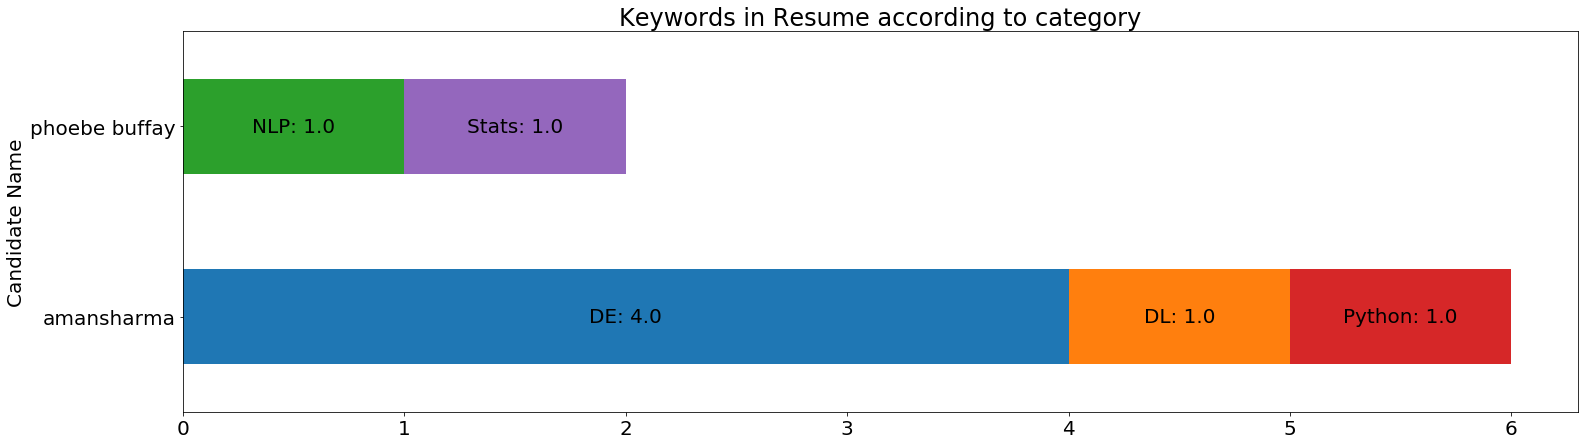

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20})
ax = candidate_data.plot.barh(title="Keywords in Resume according to category", legend=False, figsize=(25,7), stacked=True)
skills = []
for j in candidate_data.columns:
    for i in candidate_data.index:
        skill = str(j)+": " + str(candidate_data.loc[i][j])
        skills.append(skill)
patches = ax.patches
for skill, rect in zip(skills, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., skill, ha='center', va='center')
plt.show()